# **Practical assignment for Topic 9**

In the assignment, you have to use the dataset `auto-lpkm.tsv` (with quadratic features) given in the lecture and you should reuse the given code.

Your assignment consists of **three tasks**:
<br>
<br>

**Task 1**<br>
In function `GA()`, implement tournament selection. Set tournament size to 4.<br>
Do not remove the roulette wheel selection. Instead write the code so that it is easy to choose which selection method to use - from the arguments of the `GA()` function.
<br>
<br>

**Task 2**<br>
In function `GA()`, implement <a href="https://en.wikipedia.org/wiki/Crossover_(genetic_algorithm)#Uniform_crossover">uniform cross-over</a>. As discussed in the lecture, for each gene there should be 50% probability to go to the first child and other 50% probability to go to the second child. And then the other parent's gene does the opposite.<br>
Do not remove the single-point cross-over. Instead write the code so that it is easy to choose which cross-over method to use - from the arguments of the `GA()` function.
<br>
<br>

**Task 3**<br>
Evaluate the following four configurations of GA without any other configuration changes:
* Configuration 1: Roulette wheel selection and single-point cross-over.
* Configuration 2: Roulette wheel selection and uniform cross-over.
* Configuration 3: Tournament selection and single-point cross-over.
* Configuration 4: Tournament selection and uniform cross-over.

For the four evaluations, run the function on the given dataset and take note of the finally computed $R^2$ value. To do it properly, run each configuration 10 times and compute the averate $R^2$. This will help to reduce the uncertainty of the evaluations. Now compare the numbers and write conclusions.

In addition, also compare four "fitness vs. generation" diagrams - one diagram from each configuration's single run. Or if you are able to manage the plot's visual complexity, you may try to show all runs from all configurations in one plot. Finally, write conclusions about this comparison as well.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score

## Task 1

We get GA from the lecture. In the following cell, the needed modifications for Task 1 are done :

In [2]:
def GA(X, y, model, feature_names, selection_method="roulette", tournament_size=4):
  def tournament_selection(fitness, k):
    """
    Select one parent using tournament selection.

    fitness : 1D array of fitness values (smaller is better)
    k       : tournament size
    """
    # randomly choose k distinct individuals
    # indices between 0 and pop_size - 1
    candidates = np.random.choice(pop_size, size=k, replace=False)

    # the best individual in this group has the smallest fitness value
    best_candidate = candidates[np.argmin(fitness[candidates])]
    return best_candidate
  
  m = X.shape[1]

  # configuration
  pop_size = 10 + 1 # even number plus elite
  num_generations = 30
  crossover_prob = 0.9
  mutation_prob = 1 / m

  # matrices to store the current and the next generation
  pop = np.random.choice(a=[False, True], size=(pop_size, m))
  pop_next = np.empty((pop_size, m), dtype=bool)

  # overall best found soluton
  overall_best_chromosome = np.full(m, False)  # the overall best found solution
  overall_best_fitness = np.inf  # fitness of the best found solution

  # for storing statistics
  stats = np.empty((num_generations, 2))

  # GA generations (iterations)
  for generation in range(0, num_generations):

    # evaluation of each individual
    fitness = np.empty(pop_size)
    for i in range(0, pop_size):
      chromosome = pop[i, :]
      if not np.any(chromosome):
        fitness[i] = np.inf
        continue
      X_selected = X[:, chromosome]
      yHat = cross_val_predict(model, X_selected, y, cv=10)
      fitness[i] = mean_squared_error(y, yHat)

    # find the best individual of the generation
    best_individual = np.argmin(fitness)
    best_fitness = fitness[best_individual]
    best_chromosome = pop[best_individual, :]
    # save best fitness of the generation to stats
    stats[generation] = [np.ma.masked_invalid(fitness).mean(), best_fitness]
    # if better than the overall best, remember it
    if best_fitness < overall_best_fitness:
      overall_best_fitness = best_fitness
      overall_best_chromosome = best_chromosome.copy()

    # print best result in the current generation
    print(f'Generation {generation}: Best fitness = {fitness[best_individual]}')
    if feature_names.shape[0] == m:
      print(''.join(['1' if bit else '0' for bit in pop[best_individual, :]]) + ': ' + '\t'.join(feature_names[pop[best_individual, :]]))
    else:
      print(''.join(['1' if bit else '0' for bit in pop[best_individual, :]]))

    # no need to run the rest of the code for the last generation
    if generation >= num_generations - 1:
      break

    # some preparations for roulette wheel selection
    inverted_fitness = 1 / fitness
    roulette_probs = np.zeros(pop_size)
    roulette_probs[0] = inverted_fitness[0] / np.sum(inverted_fitness)
    for i in range(1, pop_size):
      roulette_probs[i] = roulette_probs[i - 1] + inverted_fitness[i] / np.sum(inverted_fitness)

    # loop through population size with step 2 so that we fully create the next population
    for i in range(0, pop_size - 1, 2):  # -1 because of the elitism

      # --- parent selection ---
      if selection_method == "tournament":
        # tournament selection (smaller fitness is better)
        parent1 = tournament_selection(fitness, tournament_size)
        parent2 = tournament_selection(fitness, tournament_size)
      else:
        # default: roulette wheel selection
        # finding the first sum of probs that is larger than a random number
        parent1 = np.argmax(roulette_probs >= np.random.rand())
        parent2 = np.argmax(roulette_probs >= np.random.rand())

      # single-point crossover (unchanged)
      if crossover_prob > np.random.rand():
        crossover_pos = np.random.randint(1, high=m)
        pop_next[i, :] =   np.hstack([pop[parent1, 0:crossover_pos], pop[parent2, crossover_pos:]])
        pop_next[i+1, :] = np.hstack([pop[parent2, 0:crossover_pos], pop[parent1, crossover_pos:]])
      else:
        pop_next[i, :] =   pop[parent1, :]
        pop_next[i+1, :] = pop[parent2, :]


    # elitist
    pop_next[-1, :] = best_chromosome

    # mutation
    mutate = np.random.rand(pop_size, m) <= mutation_prob  # mutation mask for all individuals
    mutate[-1,:] = False  # do not mutate elite
    np.logical_not(pop_next, where=mutate, out=pop_next)

    # the next population becomes the current one
    pop = pop_next.copy()

  # print the overall best result
  print()
  print('Overall best fitness =', overall_best_fitness)
  if feature_names.shape[0] == m:
    print(''.join(['1' if bit else '0' for bit in overall_best_chromosome]) + ': ' + '\t'.join(feature_names[overall_best_chromosome]))
  else:
    print(''.join(['1' if bit else '0' for bit in overall_best_chromosome]))

  # in addition, compute coefficient of determination
  X_selected = X[:, overall_best_chromosome]
  yHat = cross_val_predict(model, X_selected, y, cv=10)
  overall_best_R2 = r2_score(y, yHat)
  print('Overall best R2 =', overall_best_R2)

  return stats, overall_best_R2

In [3]:
data = pd.read_csv("auto-lpkm.tsv", sep="\t", header=0)

# All columns except target
feature_names = data.columns.values[:-1]
X = data.iloc[:, :-1].values
y = data["l100km"].values

model = LinearRegression()

# original behaviour: roulette-wheel selection
stats_roulette, R2_roulette = GA(X, y, model, feature_names, selection_method="roulette")

# new behaviour: tournament selection with tournament size 4
stats_tournament, R2_tournament = GA(X, y, model, feature_names,
                                     selection_method="tournament",
                                     tournament_size=4)


Generation 0: Best fitness = 2.0854366409857614
10001111010011: id	weight_lbs	weight_kg	acceleration	model_year	more_info_1	more_info_4	more_info_5
Generation 1: Best fitness = 2.057920950070451
01010111010100: cylinders	horsepower	weight_kg	acceleration	model_year	more_info_1	more_info_3
Generation 2: Best fitness = 2.0486571907424205
01010111101011: cylinders	horsepower	weight_kg	acceleration	model_year	color	more_info_2	more_info_4	more_info_5
Generation 3: Best fitness = 1.994986814471953
01010111000011: cylinders	horsepower	weight_kg	acceleration	model_year	more_info_4	more_info_5
Generation 4: Best fitness = 1.9933965319761344
01010111000010: cylinders	horsepower	weight_kg	acceleration	model_year	more_info_4
Generation 5: Best fitness = 1.9933965319761344
01010111000010: cylinders	horsepower	weight_kg	acceleration	model_year	more_info_4
Generation 6: Best fitness = 1.9933965319761344
01010111000010: cylinders	horsepower	weight_kg	acceleration	model_year	more_info_4
Generation 7: 

## Task 2

We start again using the lesson's function :

In [4]:
def GA(X, y, model, feature_names, selection_method="roulette", tournament_size=4, crossover_method="single"):
  def tournament_selection(fitness, k):
    """
    Select one parent using tournament selection.

    fitness : 1D array of fitness values (smaller is better)
    k       : tournament size
    """
    # randomly choose k distinct individuals
    # indices between 0 and pop_size - 1
    candidates = np.random.choice(pop_size, size=k, replace=False)

    # the best individual in this group has the smallest fitness value
    best_candidate = candidates[np.argmin(fitness[candidates])]
    return best_candidate
  
  m = X.shape[1]

  # configuration
  pop_size = 10 + 1 # even number plus elite
  num_generations = 30
  crossover_prob = 0.9
  mutation_prob = 1 / m

  # matrices to store the current and the next generation
  pop = np.random.choice(a=[False, True], size=(pop_size, m))
  pop_next = np.empty((pop_size, m), dtype=bool)

  # overall best found soluton
  overall_best_chromosome = np.full(m, False)  # the overall best found solution
  overall_best_fitness = np.inf  # fitness of the best found solution

  # for storing statistics
  stats = np.empty((num_generations, 2))

  # GA generations (iterations)
  for generation in range(0, num_generations):

    # evaluation of each individual
    fitness = np.empty(pop_size)
    for i in range(0, pop_size):
      chromosome = pop[i, :]
      if not np.any(chromosome):
        fitness[i] = np.inf
        continue
      X_selected = X[:, chromosome]
      yHat = cross_val_predict(model, X_selected, y, cv=10)
      fitness[i] = mean_squared_error(y, yHat)

    # find the best individual of the generation
    best_individual = np.argmin(fitness)
    best_fitness = fitness[best_individual]
    best_chromosome = pop[best_individual, :]
    # save best fitness of the generation to stats
    stats[generation] = [np.ma.masked_invalid(fitness).mean(), best_fitness]
    # if better than the overall best, remember it
    if best_fitness < overall_best_fitness:
      overall_best_fitness = best_fitness
      overall_best_chromosome = best_chromosome.copy()

    # print best result in the current generation
    print(f'Generation {generation}: Best fitness = {fitness[best_individual]}')
    if feature_names.shape[0] == m:
      print(''.join(['1' if bit else '0' for bit in pop[best_individual, :]]) + ': ' + '\t'.join(feature_names[pop[best_individual, :]]))
    else:
      print(''.join(['1' if bit else '0' for bit in pop[best_individual, :]]))

    # no need to run the rest of the code for the last generation
    if generation >= num_generations - 1:
      break

    # some preparations for roulette wheel selection
    inverted_fitness = 1 / fitness
    roulette_probs = np.zeros(pop_size)
    roulette_probs[0] = inverted_fitness[0] / np.sum(inverted_fitness)
    for i in range(1, pop_size):
      roulette_probs[i] = roulette_probs[i - 1] + inverted_fitness[i] / np.sum(inverted_fitness)

    # loop through population size with step 2 so that we fully create the next population
    for i in range(0, pop_size - 1, 2):  # -1 because of the elitism

      # --- parent selection ---
      if selection_method == "tournament":
        # tournament selection (smaller fitness is better)
        parent1 = tournament_selection(fitness, tournament_size)
        parent2 = tournament_selection(fitness, tournament_size)
      else:
        # default: roulette wheel selection
        # finding the first sum of probs that is larger than a random number
        parent1 = np.argmax(roulette_probs >= np.random.rand())
        parent2 = np.argmax(roulette_probs >= np.random.rand())

      # crossover
      if crossover_prob > np.random.rand():

          if crossover_method == "uniform":
              # --- uniform crossover ---
              # for each gene position, we choose from parent1 or parent2 with 0.5 probability
              mask = np.random.rand(m) < 0.5  # True/False mask of length m

              child1 = np.empty(m, dtype=bool)
              child2 = np.empty(m, dtype=bool)

              # genes where mask is True come from parent1 for child1 and from parent2 for child2
              child1[mask] = pop[parent1, mask]
              child2[mask] = pop[parent2, mask]

              # genes where mask is False come from the opposite parent
              child1[~mask] = pop[parent2, ~mask]
              child2[~mask] = pop[parent1, ~mask]

              pop_next[i, :]   = child1
              pop_next[i+1, :] = child2

          else:
              # --- single-point crossover (original behaviour) ---
              crossover_pos = np.random.randint(1, high=m)
              pop_next[i, :]   = np.hstack([pop[parent1, 0:crossover_pos], pop[parent2, crossover_pos:]])
              pop_next[i+1, :] = np.hstack([pop[parent2, 0:crossover_pos], pop[parent1, crossover_pos:]])

      else:
          # no crossover: children are exact copies of the parents
          pop_next[i, :]   = pop[parent1, :]
          pop_next[i+1, :] = pop[parent2, :]


    # elitist
    pop_next[-1, :] = best_chromosome

    # mutation
    mutate = np.random.rand(pop_size, m) <= mutation_prob  # mutation mask for all individuals
    mutate[-1,:] = False  # do not mutate elite
    np.logical_not(pop_next, where=mutate, out=pop_next)

    # the next population becomes the current one
    pop = pop_next.copy()

  # print the overall best result
  print()
  print('Overall best fitness =', overall_best_fitness)
  if feature_names.shape[0] == m:
    print(''.join(['1' if bit else '0' for bit in overall_best_chromosome]) + ': ' + '\t'.join(feature_names[overall_best_chromosome]))
  else:
    print(''.join(['1' if bit else '0' for bit in overall_best_chromosome]))

  # in addition, compute coefficient of determination
  X_selected = X[:, overall_best_chromosome]
  yHat = cross_val_predict(model, X_selected, y, cv=10)
  overall_best_R2 = r2_score(y, yHat)
  print('Overall best R2 =', overall_best_R2)

  return stats, overall_best_R2

In [5]:
# roulette + single-point crossover (original behaviour)
stats_r_single, R2_r_single = GA(
    X, y, model, feature_names,
    selection_method="roulette",
    crossover_method="single"
)

# roulette + uniform crossover
stats_r_uniform, R2_r_uniform = GA(
    X, y, model, feature_names,
    selection_method="roulette",
    crossover_method="uniform"
)

# tournament + single-point crossover
stats_t_single, R2_t_single = GA(
    X, y, model, feature_names,
    selection_method="tournament",
    tournament_size=4,
    crossover_method="single"
)

# tournament + uniform crossover
stats_t_uniform, R2_t_uniform = GA(
    X, y, model, feature_names,
    selection_method="tournament",
    tournament_size=4,
    crossover_method="uniform"
)


Generation 0: Best fitness = 2.1105928452296867
00111011111000: displacement	horsepower	weight_lbs	acceleration	model_year	color	more_info_1	more_info_2
Generation 1: Best fitness = 2.093095145573516
00111011011100: displacement	horsepower	weight_lbs	acceleration	model_year	more_info_1	more_info_2	more_info_3
Generation 2: Best fitness = 2.0757318125100976
00111011011000: displacement	horsepower	weight_lbs	acceleration	model_year	more_info_1	more_info_2
Generation 3: Best fitness = 2.0757318125100976
00111011011000: displacement	horsepower	weight_lbs	acceleration	model_year	more_info_1	more_info_2
Generation 4: Best fitness = 2.0690822586224744
00101101110110: displacement	weight_lbs	weight_kg	model_year	color	more_info_1	more_info_3	more_info_4
Generation 5: Best fitness = 2.0690822586224744
00101101110110: displacement	weight_lbs	weight_kg	model_year	color	more_info_1	more_info_3	more_info_4
Generation 6: Best fitness = 2.0680469604432177
00011111010110: horsepower	weight_lbs	weight_

## Task 3


In [6]:
# number of independent runs for each configuration
n_runs = 10

# list of configurations: (name, selection_method, crossover_method)
configurations = [
    ("roulette_single",   "roulette",   "single"),
    ("roulette_uniform",  "roulette",   "uniform"),
    ("tournament_single", "tournament", "single"),
    ("tournament_uniform","tournament", "uniform"),
]

results = {}  # dictionary to store all results


for config_name, selection_method, crossover_method in configurations:
    print(f"Running configuration: {config_name} "
          f"(selection={selection_method}, crossover={crossover_method})")

    R2_values = []
    stats_values = []   # will store the GA stats for each run

    for run in range(n_runs):
        print(f"  Run {run+1}/{n_runs} ...", end="")

        stats, best_R2 = GA(
            X, y, model, feature_names,
            selection_method=selection_method,
            tournament_size=4,              # tournament size fixed to 4
            crossover_method=crossover_method
        )

        R2_values.append(best_R2)
        stats_values.append(stats)

        print(f"  best R2 = {best_R2:.4f}")

    R2_values = np.array(R2_values)
    stats_values = np.array(stats_values)  # shape: (n_runs, num_generations, 2)

    # average stats across runs (for plotting fitness curves later)
    mean_stats = np.mean(stats_values, axis=0)  # shape: (num_generations, 2)

    results[config_name] = {
        "selection_method": selection_method,
        "crossover_method": crossover_method,
        "R2_values": R2_values,
        "mean_R2": np.mean(R2_values),
        "std_R2": np.std(R2_values),
        "stats_values": stats_values,
        "mean_stats": mean_stats,
    }

print("\nSummary of mean R2 over all configurations:\n")
for config_name, res in results.items():
    print(f"{config_name:18s}  mean R2 = {res['mean_R2']:.4f}  "
          f"(std = {res['std_R2']:.4f})")

Running configuration: roulette_single (selection=roulette, crossover=single)
  Run 1/10 ...Generation 0: Best fitness = 2.024601701238096
00001011010010: weight_lbs	acceleration	model_year	more_info_1	more_info_4
Generation 1: Best fitness = 2.024601701238096
00001011010010: weight_lbs	acceleration	model_year	more_info_1	more_info_4
Generation 2: Best fitness = 2.024601701238096
00001011010010: weight_lbs	acceleration	model_year	more_info_1	more_info_4
Generation 3: Best fitness = 2.024601701238096
00001011010010: weight_lbs	acceleration	model_year	more_info_1	more_info_4
Generation 4: Best fitness = 2.024601701238096
00001011010010: weight_lbs	acceleration	model_year	more_info_1	more_info_4
Generation 5: Best fitness = 2.0218809074874797
10101001010011: id	displacement	weight_lbs	model_year	more_info_1	more_info_4	more_info_5
Generation 6: Best fitness = 2.0218809074874797
10101001010011: id	displacement	weight_lbs	model_year	more_info_1	more_info_4	more_info_5
Generation 7: Best fit

In [7]:
summary_rows = []
for config_name, res in results.items():
    summary_rows.append({
        "configuration": config_name,
        "selection_method": res["selection_method"],
        "crossover_method": res["crossover_method"],
        "mean_R2": res["mean_R2"],
        "std_R2": res["std_R2"],
    })

summary_df = pd.DataFrame(summary_rows)
display(summary_df)

,configuration,selection_method,crossover_method,mean_R2,std_R2
0,roulette_single,roulette,single,0.864420,0.000441
1,roulette_uniform,roulette,uniform,0.864396,0.000338
2,tournament_single,tournament,single,0.864752,0.000110
3,tournament_uniform,tournament,uniform,0.864797,0.000091


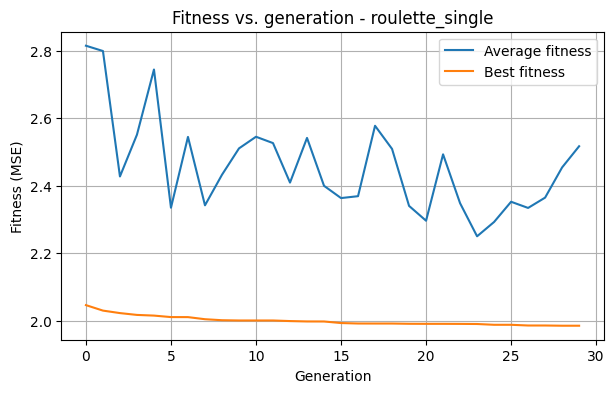

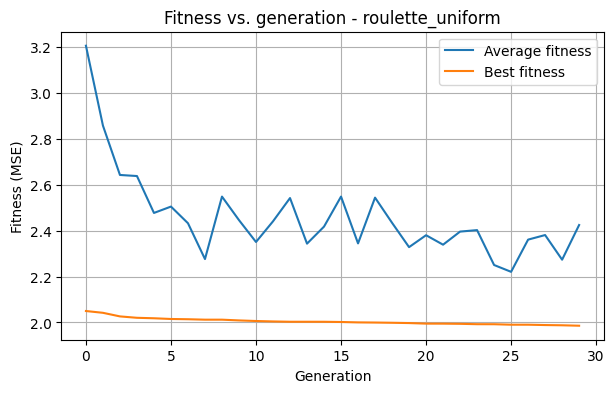

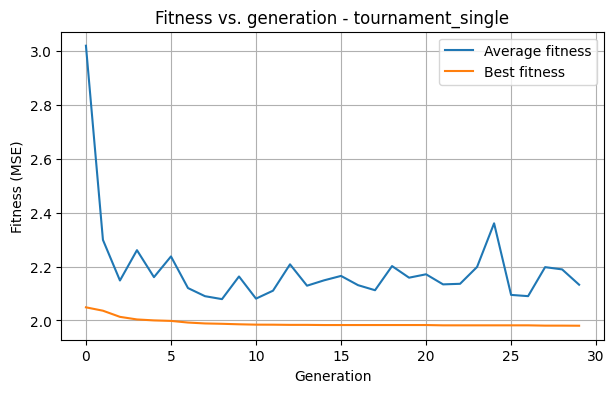

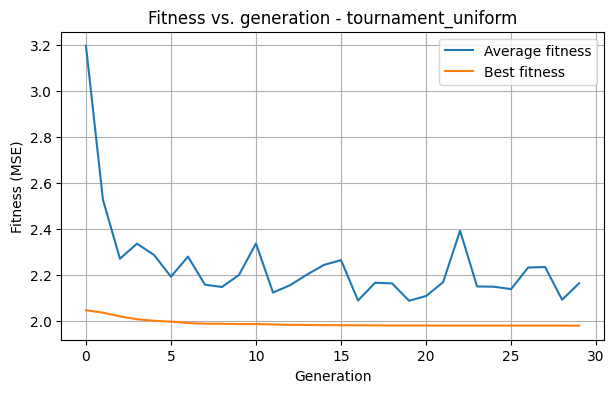

In [8]:
num_generations = next(iter(results.values()))["mean_stats"].shape[0]
generations = np.arange(num_generations)

for config_name, res in results.items():
    mean_stats = res["mean_stats"]  # shape: (num_generations, 2)
    avg_fitness = mean_stats[:, 0]  # column 0: average fitness in the population
    best_fitness = mean_stats[:, 1] # column 1: best fitness in the population

    plt.figure(figsize=(7, 4))
    plt.plot(generations, avg_fitness, label="Average fitness")
    plt.plot(generations, best_fitness, label="Best fitness")

    plt.xlabel("Generation")
    plt.ylabel("Fitness (MSE)")
    plt.title(f"Fitness vs. generation - {config_name}")
    plt.legend()
    plt.grid(True)
    plt.show()


## Conclusion

The four configurations of genetic algorithm give very close results between them. The mean R² score is nearly the same in all cases, about 0.864, with very few variations. This means all tested methods are stable and efficient for this particular problem.

Tournament selection give a better mean result than roulette selection, and it gets fitness to lower more at the beginning. This shows that tournament selection allows the algorithm to advance more quickly towards right solutions.

Uniform crossover does not bring major change upon single-point crossover, but it makes results more regular, more stable from one try to another.

Watching the graphics, we can see that fitness collapses during the first generations, then stabilizes. The combination tournament selection + uniform crossover gets the best mean performance and greatest stability.

To sum up, all configurations work, but the tournament with uniform crossover is the best option with a slight margin.

---
**After the tasks are done, submit this file. Do not clear it's output - all print-outs and diagrams should be left in the file.**